In [77]:
import numpy as np
import pandas as pd
import random


#Sklearn functions
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, train_test_split,StratifiedKFold,RepeatedKFold


from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import roc_auc_score, plot_roc_curve, confusion_matrix
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

from imblearn.over_sampling import SVMSMOTE
from imblearn.pipeline import Pipeline

import matplotlib.pyplot as plt

from skbio.stats.ordination import pcoa
from skbio.stats.distance import permanova
from skbio.diversity import beta_diversity

import shap

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


Actions:
1. Read Metaphlan table and Metadata.
2. Filter out based on prevalence and taxonomic level
3. Split data (folds)
4. Test prediction model


Some other interesting approaches:
1. Try Over/Under- sampling using SMOTE https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/


In [2]:
def Creat_taxa_table(df):
    new_columns = []
    new_names = []
    non_zero_proportions = []
    Levels = []
    for column in df.columns:
        # Extract the name after the last '.' in the column header
        last_dot_index = column.rfind('.')
        new_column_name = column[last_dot_index + 1:]
        new_columns.append(column)
        new_names.append(new_column_name)

        # Calculate the proportion of non-zero values in the column
        non_zero_count = df[column].astype(bool).sum()
        total_count = df[column].count()
        non_zero_proportion = non_zero_count / total_count
        non_zero_proportions.append(non_zero_proportion)

        #Get info about taxonomy level
        level = new_column_name.split("__")[0]
        Levels.append(level)
    new_df = pd.DataFrame({
        'Taxonomy': new_columns,
        'Short_taxonomy': new_names,
        'Prevalence': non_zero_proportions,
        'Taxonomy_level' : Levels
    })

    return new_df
    
def Shorten_names(df, Info):
    short_names = Info['Short_taxonomy'].tolist()
    new_column_names = dict(zip(df.drop(columns=["NEXT_ID"]).columns, short_names))
    new_column_names["NEXT_ID"] = "NEXT_ID"
    df = df.rename(columns=new_column_names)
    return(df)
def Match_id_type(Denominators, DF): 
    DF_change = DF[["NEXT_ID", "NG_ID"]]
    Denominators = pd.merge(DF_change, Denominators, on='NG_ID')

    Denominators = Denominators.drop('NG_ID', axis=1)
    DF = DF.drop('NG_ID', axis=1)
    
    return(Denominators, DF)


In [4]:
DF = pd.read_csv("Data/Taxonomy_for_prediction.tsv", delimiter="\t")
Meta = pd.read_csv("Data/Metadata_for_analysis_cross.tsv", delimiter="\t")
Denominators = pd.read_csv("Data/Table_GeomMean.tsv", delimiter="\t")
Denominators, DF = Match_id_type(Denominators, DF)


#Remove unclassified.
DF = DF.drop(columns=['UNCLASSIFIED'])
#Get table with: 1. Taxa, 2. Short name, 3. Prevalence
Info_taxonomy = Creat_taxa_table(DF.drop(columns=["NEXT_ID"]) )
#Use short names
DF = Shorten_names(DF, Info_taxonomy)

We will create a function that accepts:
1.  Metaphlan taxonomy | taxonomic level | Prevalence threshold  and filters to have the prediciton table
2.  A Phenotype to predict
3. Fold strategy

In [5]:
def Prepare_features_X(df, Level="all", Prev_threshold=0, info = Info_taxonomy, Transform="clr", Den=Denominators):
    #filter prevalence
    info = info[info["Prevalence"] >= Prev_threshold]
    if Level != "all":
        info = info[info["Taxonomy_level"] == Level]
    ID = df["NEXT_ID"]
    df = df.drop(columns=["NEXT_ID"])    
    if Transform == "clr":
        #CLR transform the data
        Den = Den[Den['NEXT_ID'].isin(ID.tolist()) ]    
        df = CLR_transform(df, denominators=Den )
    elif Transform == "arcsin":
        df = df.apply(ast_transform, axis=1)
    #Filter
    df_filter = df[ info["Short_taxonomy"] ]
    df_filter.insert(0, "NEXT_ID", ID)
    return(df_filter)
def CLR_transform(df, denominators = None,epsilon=1.575357e-5):
    #1e-6
    #ID = df["NEXT_ID"]
    #df = df.drop(columns=["NEXT_ID"])
    #Add a small constant value to avoid division by zero
    df = df + epsilon
    
    if isinstance(denominators, pd.DataFrame):
        geometric_means = denominators["Denominator"]
    else:    
        # Compute the geometric mean of each row
        geometric_means = np.exp(np.log(df).mean(axis=1))
    # Divide each row by its geometric mean
    clr_df = df.div(geometric_means, axis=0)

    # Take the natural logarithm of the CLR transformed values
    clr_df = np.log(clr_df)

    #clr_df.insert(0, "NEXT_ID", ID)
    return(clr_df)
def ast_transform(x):
    x = x/x.sum()
    return(np.arcsin(np.sqrt(x))**2)
def Match_x_y(df, metadata, feature_name="infant_health_food_allergy"):
    metadata = metadata[["NEXT_ID", feature_name] ]
    merged_df = df.merge(metadata, on="NEXT_ID", how="left")
    merged_df = merged_df.dropna()
    return(merged_df)
def Make_pcoa(Input_ml, metric = "sqeuclidean", Phenotype="infant_health_food_allergy", Check_eigen=False):
    #Make a PCoA
    if metric == "bray" or metric == "braycurtis":    
        distance = beta_diversity(metric = 'braycurtis', counts = Input_ml.drop(columns = [Phenotype, "NEXT_ID"]  ) , ids= Input_ml.index)
    if metric == "euclidean" or metric == "eu" or metric == 'sqeuclidean':
        distance = beta_diversity(metric = 'sqeuclidean', counts = Input_ml.drop(columns = [Phenotype, "NEXT_ID"]  ) , ids= Input_ml.index)
    #1. Fit PCoA
    pcoa_results = pcoa(distance)
    #2. Get PCs
    pcoa_coords = pcoa_results.samples.values
    variance_explained = pcoa_results.proportion_explained
    if Check_eigen == True:
        eigenvalues = pcoa_results.eigvals
        plt.figure(figsize=(8, 6))
        plt.bar(range(1, len(eigenvalues) + 1), eigenvalues, color='b', alpha=0.7)
        plt.xlabel('Principal Component')
        plt.ylabel('Eigenvalue')
        plt.title('Scree Plot')
        plt.grid()
        plt.show()
    
    #3. Colors
    groups = Input_ml[Phenotype].unique()
    print(groups)
    colors = ['red', 'blue']
    plt.figure(figsize=(8, 6))
    for i, group in enumerate(groups):
        group_mask = (Input_ml[Phenotype] == group)
        plt.scatter(pcoa_coords[group_mask, 0], pcoa_coords[group_mask, 1], label=group, color=colors[i])

    # Add axis labels and a legend
    plt.xlabel(f'PC1 ({variance_explained[0]*100:.2f}%)')
    plt.ylabel(f'PC2 ({variance_explained[1]*100:.2f}%)')
    plt.legend(title='Group')
    plt.title('PCoA Plot with Colored Groups')
    plt.grid()
    plt.show()
    
    

In [110]:
def Run_basic_model(X,y, N_repeats_cv = 1, random_state=7644, CV=10, Model="rf", Oversampling=False):
    np.random.seed(random_state)
    random.seed(random_state)
    steps = []
    
    #print("Running: " + y)
    Y = X[y]
    X = X.drop(columns=[y, "NEXT_ID"])
    value_counts_df = Y.value_counts()

    if Oversampling == True:
        oversample = SVMSMOTE()
        steps.append(("over", oversample))        
    
    # Create the Random Forest classifier
    if Model == "rf":
        classifier = RandomForestClassifier(n_estimators=500, random_state=random_state) #100 trees
    elif Model == "xgb":
        if Oversampling == False:
            W = value_counts_df[0]/value_counts_df[1]
        else: W = 1
        classifier = xgb.XGBClassifier(random_state=random_state, scale_pos_weight=W)
        #classifier = xgb.XGBClassifier( colsample_bylevel=0.075, max_depth=6, learning_rate=0.0025, n_estimators=4000,subsample=0.6, min_child_weight=20. )
    elif Model == "Lasso":
        alpha_values = [0.005,0.01, 0.1, 1.0]  # You can adjust these values based on your data
        param_grid = {'C': alpha_values}
        lasso = LogisticRegression(penalty='l1',solver='liblinear', class_weight="balanced", random_state=random_state)
        grid_search = GridSearchCV(lasso, param_grid, cv=5, scoring='roc_auc')
        grid_search.fit(X, Y)
        classifier = grid_search.best_estimator_
        print("Best Alpha:", grid_search.best_params_['C'])

        
    steps.append(('classifier', classifier))
    pipeline = Pipeline( steps )

    # Create cross-validation strategy
    cv = RepeatedStratifiedKFold(n_splits=CV, n_repeats=N_repeats_cv, random_state=random_state)

    # Run the cross-validation and get the accuracy scores
    scores = cross_val_score(pipeline, X, Y, cv=cv, scoring='roc_auc' )

    # Print the average accuracy and standard deviation
    print("Average AUC:", scores.mean())
    print("Standard Deviation:", scores.std())

    #Get shap values
    if Model == "xgb" or Model == "rf":
        Shap = Get_shap(X,Y,classifier)
        Shap["Phenotype"] = y
        return(Shap)
    
def Check_Permanova(Input_ml, Phenotype): 
    Distance = beta_diversity(metric = 'sqeuclidean', counts = Input_ml.drop(columns = [Phenotype, "NEXT_ID"]  ) , ids= Input_ml.index)
    Result = permanova(Distance, Input_ml, column=Phenotype, permutations=999)
    P = Result["p-value"]
    print("Permanova of {P} has a P-value (999 perm) of {R}".format(P=Phenotype, R=str(P)) )
def Get_shap(X,Y,classifier):
    #Classifier fit in whole dataset
    classifier.fit(X, Y)
    #Explainer of the predicitons
    explainer = shap.TreeExplainer(classifier)
    #Get shap values from ALL samples
    shap_values_all = explainer.shap_values(X)
    #Plot: all samples and plot average importance
    shap.summary_plot(shap_values_all, X)
    shap.summary_plot(shap_values_all, plot_type='bar', feature_names=X.columns )

    ##Create DF
    Mean_shap_values =  np.abs(shap_values_all).mean(0)

    Feature_importance_df = pd.DataFrame(data=Mean_shap_values, columns=["Feature_importance"])
    Feature_importance_df.index = X.columns

    Feature_importance_df= Feature_importance_df.sort_values(by='Feature_importance', ascending=False)
    return(Feature_importance_df)


In [7]:
DF2 = Prepare_features_X(DF, Level="t", Prev_threshold=0.2, Transform="clr" )

====birth_delivery_mode_simple=====
===XGboost===
Average AUC: 0.7505885063145338
Standard Deviation: 0.06722006528880156


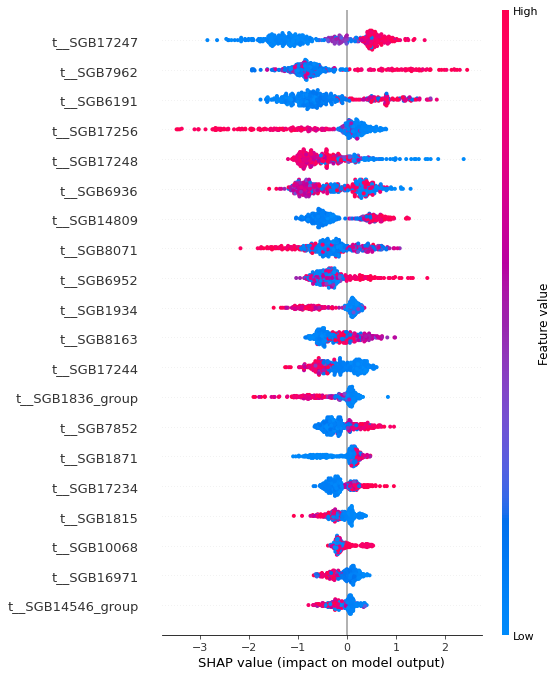

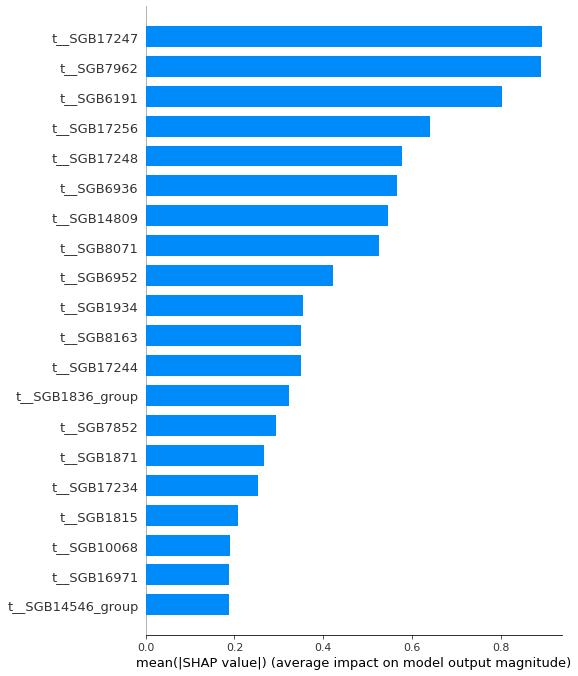

====birth_deliverybirthcard_place_delivery_simple=====
===XGboost===
Average AUC: 0.617841547868685
Standard Deviation: 0.06440576101665962


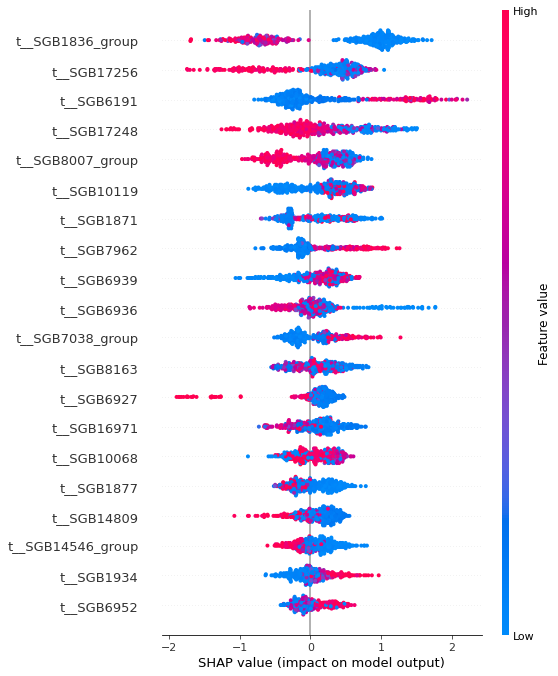

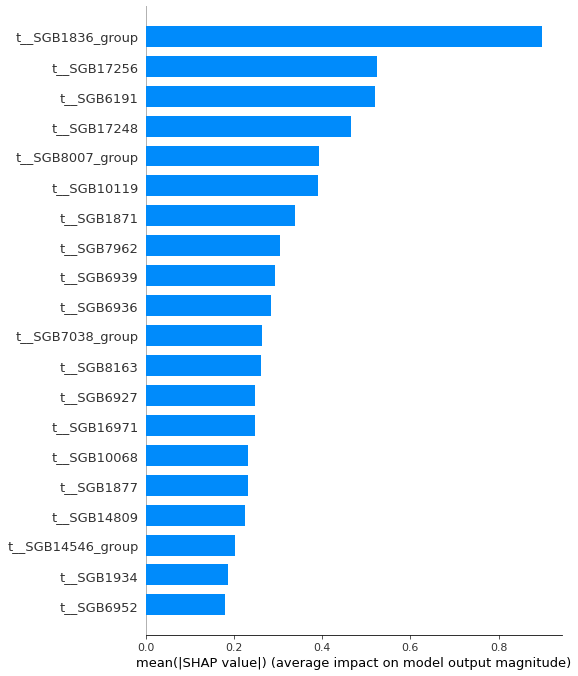

====infant_health_food_allergy=====
===XGboost===
Average AUC: 0.5871693480648704
Standard Deviation: 0.09813978807602165


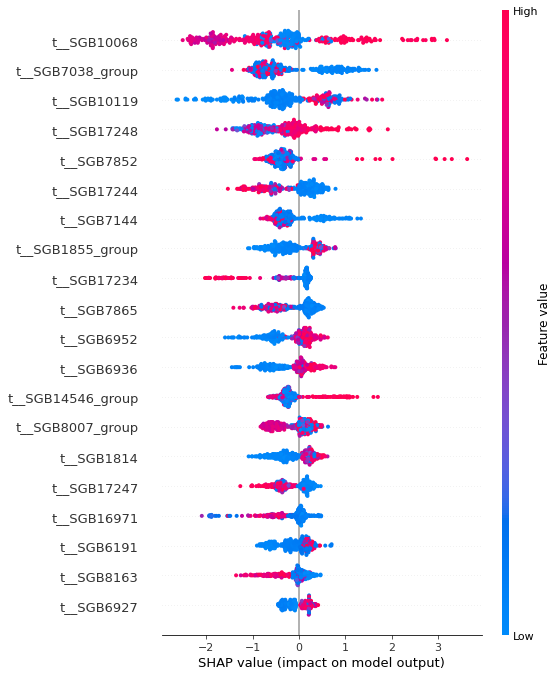

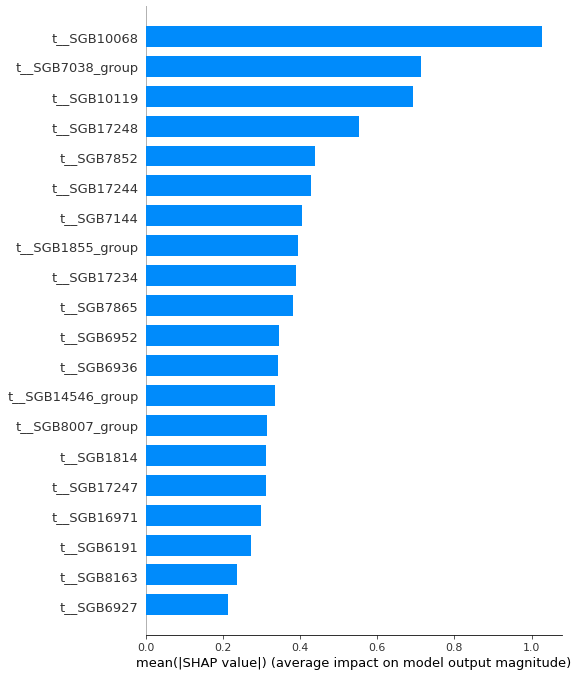

====infant_health_eczema_diagnosis_relaxed=====
===XGboost===
Average AUC: 0.4631229946524064
Standard Deviation: 0.04729989770298281


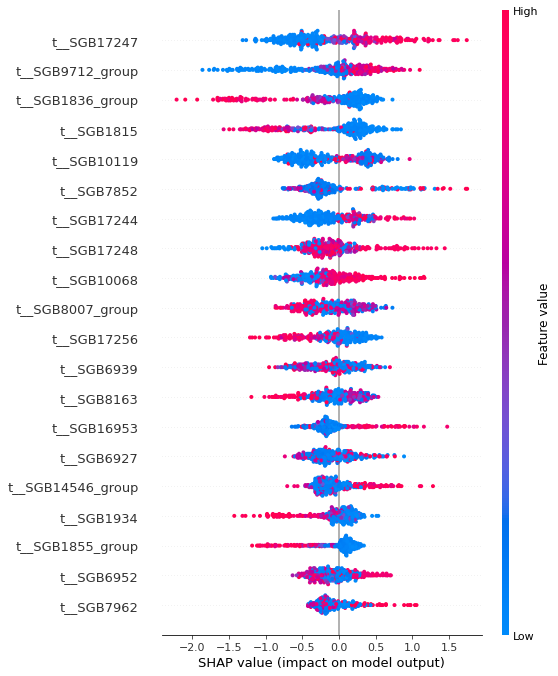

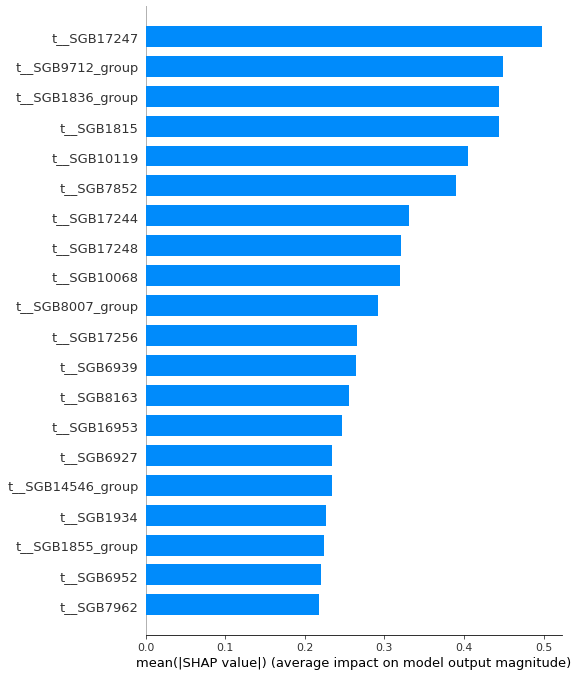

====infant_health_eczema_diagnosis_strict=====
===XGboost===
Average AUC: 0.5139738562091503
Standard Deviation: 0.08197075337314406


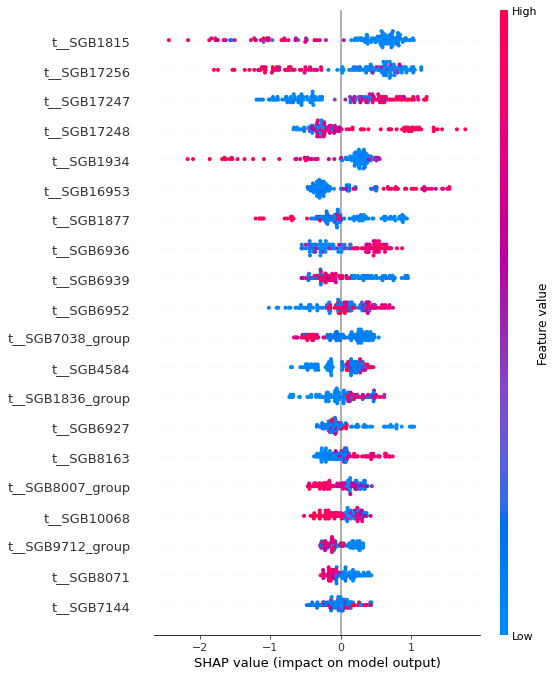

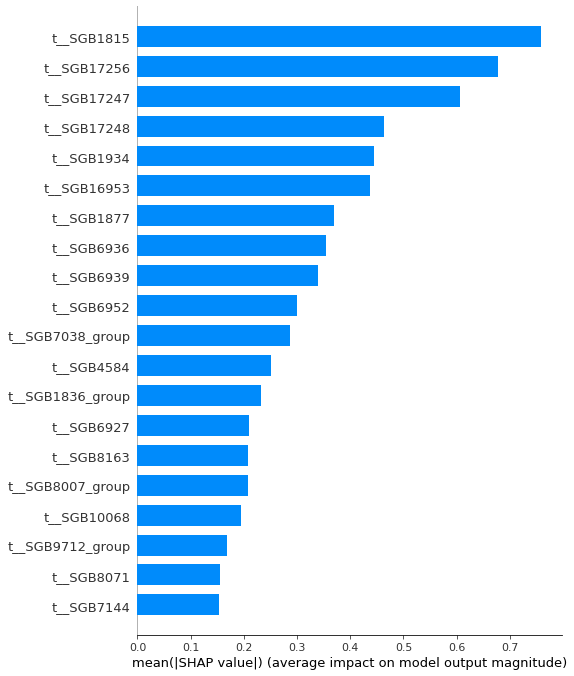

====infant_health_breathing_difficulties=====
===XGboost===
Average AUC: 0.49328138092843976
Standard Deviation: 0.05904035270232102


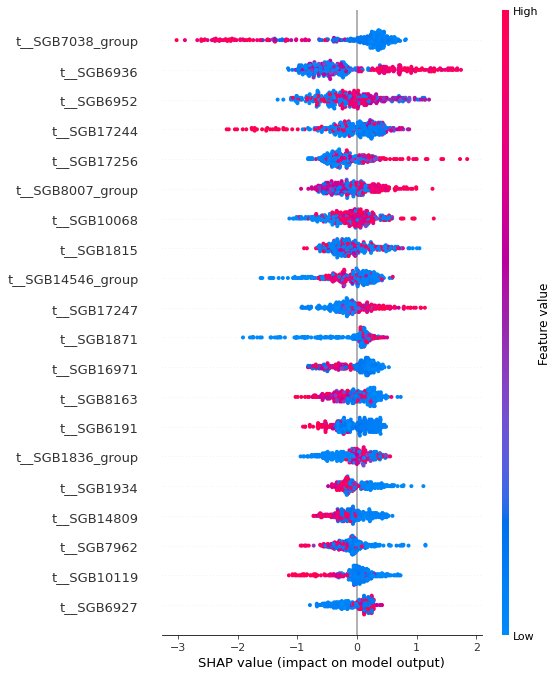

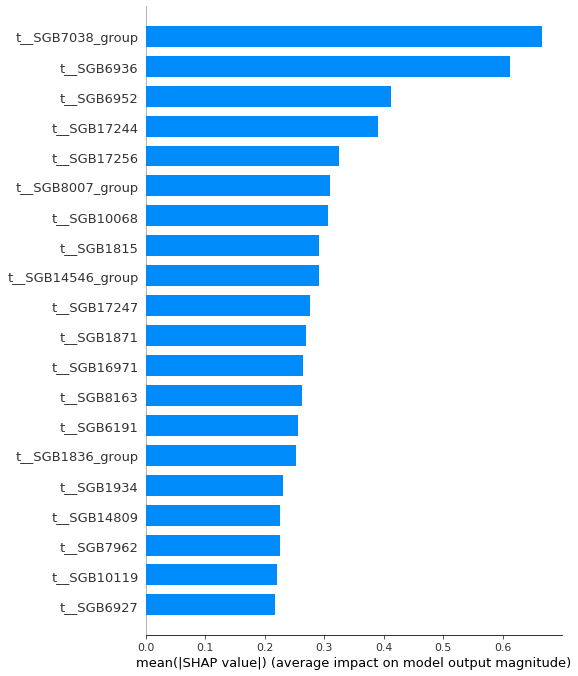

====infant_health_airway_nose_ear_throat_infection_freq=====
===XGboost===
Average AUC: 0.5877134986225895
Standard Deviation: 0.1128995026012958


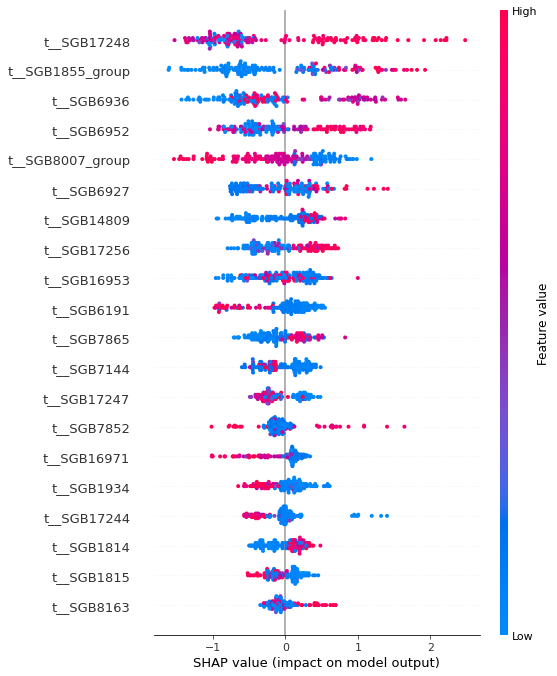

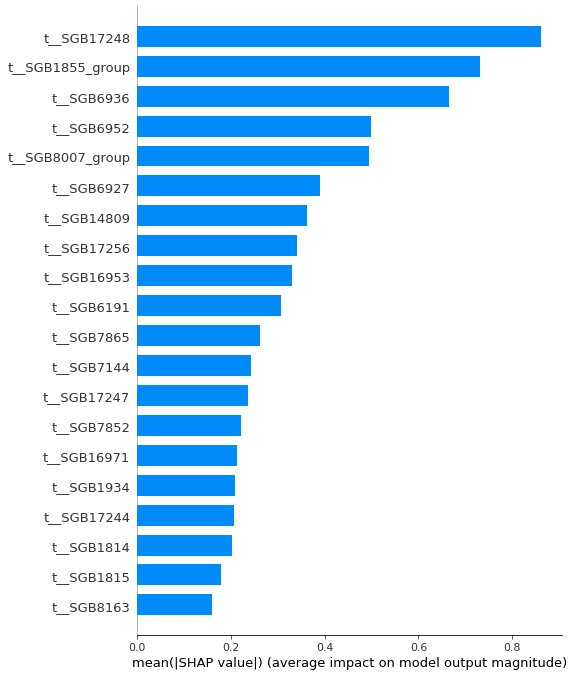

In [119]:
phenotype_mapping = {'yes': 1, 'no': 0, "post_labor_CS":1, "VG":0, "home":0, "hospital":1, "0_never":0, "1_once_twice":1, "2_three_to_five":1,"3_six_times_more":1 }
Fit = ["XGBoost"]
Iterate = ["birth_delivery_mode_simple", "birth_deliverybirthcard_place_delivery_simple", "infant_health_food_allergy", "infant_health_eczema_diagnosis_relaxed", "infant_health_eczema_diagnosis_strict", "infant_health_breathing_difficulties", "infant_health_airway_nose_ear_throat_infection_freq"]
combined_shap = pd.DataFrame()

#Test naive classifiers (without much hyperparameter optimization, for that, check below)
for Phenotype in Iterate:
    print("===={P}=====".format(P=Phenotype))
    Input_ml = Match_x_y(DF2, Meta, Phenotype)
    Input_ml[Phenotype] = Input_ml[Phenotype].map(phenotype_mapping)
    Input_ml = Input_ml[Input_ml[Phenotype].isin([0,1])]
    if "Plot" in Fit:
        Make_pcoa(Input_ml, "sqeuclidean", Phenotype, Check_eigen=True )
    if "Lasso" in Fit:
        print("===Lasso===")
        Run_basic_model(Input_ml, Phenotype, CV=5, Oversampling=False, Model="Lasso")
    if "XGBoost" in Fit:
        print("===XGboost===")
        Shap = Run_basic_model(Input_ml, Phenotype, CV=5, Model="xgb", Oversampling=False, N_repeats_cv=5 )
        combined_shap = pd.concat([combined_shap, Shap], axis=0)
    if "RF" in Fit:
        print("===RF===")
        Run_basic_model(Input_ml, Phenotype, CV=5, Model="rf", Oversampling=False, N_repeats_cv=5 )
    if "Permanova" in Fit:
        print("===Permanova===")
        Check_Permanova(Input_ml, Phenotype)

In [21]:
#birth_deliverybirthcard_place_delivery_simple is enriched in vaginal delivery. Remove CS deliver samples and repaeat assocation.

Meta_vd = Meta.drop(Meta[(Meta['birth_delivery_mode_simple'] == 'post_labor_CS') | (Meta['birth_delivery_mode_simple'].isna())].index)

Input_ml = Match_x_y(DF2, Meta_vd, "birth_deliverybirthcard_place_delivery_simple")
Input_ml["birth_deliverybirthcard_place_delivery_simple"] = Input_ml["birth_deliverybirthcard_place_delivery_simple"].map( {"home":0, "hospital":1} )
Input_ml = Input_ml[Input_ml["birth_deliverybirthcard_place_delivery_simple"].isin([0,1])]

Run_basic_model(Input_ml, "birth_deliverybirthcard_place_delivery_simple", CV=5, Model="xgb", Oversampling=False, N_repeats_cv=5 )

#We still get a similar AUC, meaning that the signal was not driven by VD

Average AUC: 0.6216489499611096
Standard Deviation: 0.06645742191679509


Now, we will fit the regression phenotypes:

In [74]:
Phenotype = 'infant_growth_standardized_weight_slope_kg'
stats_growth = Meta[Phenotype].agg(['mean', 'median', 'std', 'min', 'max'])
print(stats_growth)
#Remember to standarize in the pipeline.
Input_ml = Match_x_y(DF2, Meta, Phenotype)


Y = Input_ml[Phenotype]
X = Input_ml.drop(columns=[Phenotype, "NEXT_ID"])

model = xgb.XGBRegressor(random_state=4322) 
steps = [] #[('scaler', StandardScaler())]
steps.append(('regressor', model))
pipeline = Pipeline(steps)

cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=23432)
scores = cross_val_score(pipeline, X, Y, cv=cv, scoring='r2' )

print("Average R2:", scores.mean())
print("Standard Deviation:", scores.std())

mean        0.066793
median     -0.082203
std        16.109388
min       -45.437625
max       100.726183
Name: infant_growth_standardized_weight_slope_kg, dtype: float64
Average R2: -0.27889690544805407
Standard Deviation: 0.17194351949384887


Finally, we will check multilevel prediction

In [73]:
phenotype_mapping = { "0_never":0, "1_once_twice":1, "2_three_to_five":2 }


Phenotype = "infant_health_airway_nose_ear_throat_infection_freq"

stats_frqInfection =  Meta["infant_health_airway_nose_ear_throat_infection_freq"].value_counts()
print(stats_frqInfection)
Meta_anal = Meta[Meta[Phenotype] != '3_six_times_more']

Input_ml = Match_x_y(DF2, Meta_anal, Phenotype)

Input_ml[Phenotype] = Input_ml[Phenotype].map(phenotype_mapping)
Input_ml = Input_ml[Input_ml[Phenotype].isin([0,1,2])]


np.random.seed(1234)
random.seed(233)
steps = []
    
Y = Input_ml[Phenotype]
X = Input_ml.drop(columns=[Phenotype, "NEXT_ID"])

classifier = xgb.XGBClassifier(random_state=2334)
 
steps.append(('classifier', classifier))
pipeline = Pipeline( steps )

# Create cross-validation strategy
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=12341)

# Run the cross-validation and get the accuracy scores
scores = cross_val_score(pipeline, X, Y, cv=cv, scoring='roc_auc_ovr' )

# Print the average accuracy and standard deviation
print("Average AUC:", scores.mean())
print("Standard Deviation:", scores.std())




0_never             158
1_once_twice         67
2_three_to_five      15
3_six_times_more      5
Name: infant_health_airway_nose_ear_throat_infection_freq, dtype: int64
[0.38560606 0.54208754 0.49705387 0.56734007 0.46464646 0.48560606
 0.53367003 0.40361953 0.44276094 0.63888889 0.34090909 0.47348485
 0.54124579 0.53240741 0.3543771  0.30151515 0.54545455 0.51978114
 0.62205387 0.4452862  0.56439394 0.38552189 0.48695286 0.49579125
 0.63888889]
Average AUC: 0.4883737373737374
Standard Deviation: 0.08874965602992915


In [125]:
#save shap
combined_shap_merge = combined_shap.reset_index(inplace=False)
combined_shap_merge
#combined_shap = combined_shap.merge(Info_taxonomy, left_index=True, right_on='common_column')
combined_shap_merge = combined_shap_merge.merge(Info_taxonomy, left_on='index', right_on='Short_taxonomy', how='left')
combined_shap_merge.drop(columns= ["index", "Taxonomy_level"], inplace=True)
combined_shap_merge.to_csv("Shap_values.csv")

In [79]:
def HyperSelect_XGB(X = Input_ml , y = "infant_health_breathing_difficulties", N_repeats_cv = 1, CV=5, random_state=7644, Oversampling=False
):
    steps = []
    #Get Y and X
    Y = X[y]
    X = X.drop(columns=[y, "NEXT_ID"])
    value_counts_df = Y.value_counts()
    #include oversampling strategy
    if Oversampling:
        oversample = SVMSMOTE()
        steps.append(("over", oversample))
    if not Oversampling:
        W = sum(Y) / len(Y)
    else: W = 1
    classifier = xgb.XGBClassifier(random_state=random_state, scale_pos_weight=W)

    steps.append(('classifier', classifier))
    pipeline = Pipeline(steps)


    # Define the hyperparameter grid for XGBoost
    param_grid = {
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__max_depth': [3, 5, 7],
        'classifier__min_child_weight': [1, 3, 5],
        'classifier__subsample': [0.8, 1.0],
        'classifier__colsample_bytree': [0.8, 1.0]
    }

    # Create cross-validation strategy
    cv = RepeatedStratifiedKFold(n_splits=CV, n_repeats=N_repeats_cv, random_state=random_state)

    # Perform grid search with cross-validation
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=cv, scoring='roc_auc')
    grid_search.fit(X, Y)

    # Print the best hyperparameters and corresponding performance
    print("Best Hyperparameters:", grid_search.best_params_)
    print("Best AUC Score:", grid_search.best_score_)

    # Get the best model from the grid search
    best_model = grid_search.best_estimator_

    # Print the average AUC and standard deviation from cross-validation using the best model
    scores = cross_val_score(best_model, X, Y, cv=cv, scoring='roc_auc')
    print("Average AUC with Best Model:", scores.mean())
    print("Standard Deviation:", scores.std())

Non-function version of fit, to play around

1    72
0    39
Name: infant_health_eczema_diagnosis_strict, dtype: int64


/Users/sergio/Documents/PhD/AutoEcoders/DeepLearning/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/sergio/Documents/PhD/AutoEcoders/DeepLearning/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


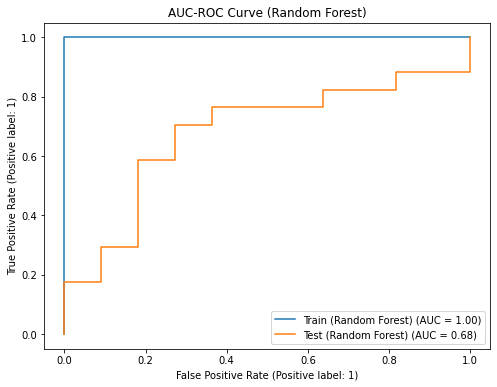

    1   0
1  72   0
0   0  39
Numbers:
1    72
0    39
Name: infant_health_eczema_diagnosis_strict, dtype: int64
Numbers test
1    72
0    39
Name: infant_health_eczema_diagnosis_strict, dtype: int64
Numbers train
1    17
0    11
Name: infant_health_eczema_diagnosis_strict, dtype: int64
Confusion Matrix:


,1,0
1,14,3
0,8,3


In [104]:
Phenotype = "infant_health_eczema_diagnosis_strict"
Input_ml = Match_x_y(DF2, Meta, Phenotype)
Input_ml[Phenotype] = Input_ml[Phenotype].map(phenotype_mapping)
#HyperSelect_XGB(Input_ml, Phenotype, CV=5, Model="xgb", Oversampling=True )


Y = Input_ml[Phenotype]
X = Input_ml.drop(columns=[Phenotype, "NEXT_ID"])
value_counts_df = Y.value_counts()


#model = xgb.XGBClassifier( colsample_bylevel=0.075, max_depth=6, learning_rate=0.0025, n_estimators=4000,subsample=0.6, min_child_weight=20. )
model = xgb.XGBClassifier(random_state=4322, scale_pos_weight=100*(value_counts_df[1]/sum(value_counts_df)), alpha =1, reg_lambda = 1 , gamma=1 )
#model = LogisticRegression(penalty='l1', C = 0.11,solver='liblinear', random_state=4343)
#model = RandomForestClassifier(n_estimators=500, random_state=3423423)

#{'max_depth': 10, 'learning_rate': 0.083248589398113, 'n_estimators': 184, 
# 'subsample': 0.8981097991959652, 'colsample_bylevel': 0.893813991379661,
# 'lambda': 3, 'alpha': 3, 'gamma': 3, 'scale_pos_weight': 56}
model = xgb.XGBClassifier(random_state=4322, scale_pos_weight= value_counts_df[1]/value_counts_df[0] )


steps = []
steps.append(('classifier', model))
pipeline = Pipeline(steps)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=2234)

Oversampling = False
if Oversampling == True:
    oversample = SVMSMOTE()
    steps = [("over", oversample)] 
    pipeline = Pipeline(steps)
    X_train, y_train = pipeline.fit_resample(X_train, y_train)
value_counts_df = y_train.value_counts()
print(value_counts_df)
    
    
# Fit the model on the training data
model.fit(X_train, y_train)

# Plot the AUC-ROC curve for both training and testing sets
plt.figure(figsize=(8, 6))
plot_roc_curve(model, X_train, y_train, ax=plt.gca(), name="Train (Random Forest)")
plot_roc_curve(model, X_test, y_test, ax=plt.gca(), name="Test (Random Forest)")
plt.title("AUC-ROC Curve (Random Forest)")
plt.show()


cm_sum = np.zeros((len(value_counts_df), len(value_counts_df)), dtype=float)
    
Y_pred_Train = model.predict(X_train)
cm_sum_train = confusion_matrix(y_train, Y_pred_Train, labels=value_counts_df.index)
print(pd.DataFrame(cm_sum_train, index=value_counts_df.index, columns=value_counts_df.index))

    
Y_pred = model.predict(X_test)
cm_sum = confusion_matrix(y_test, Y_pred, labels=value_counts_df.index)

print("Numbers:")
print(value_counts_df)
print("Numbers test")
print(y_train.value_counts())
print("Numbers train")
print(y_test.value_counts())


print("Confusion Matrix:")
pd.DataFrame(cm_sum, index=value_counts_df.index, columns=value_counts_df.index)


Trying a genetic algorithm for hyperparameter selction. This is very time consuming. It is a deep search in the hyperparemeter space (inspired by biological rules of evolution).


In [79]:
def HyperSelect_genetic(X, y, Model="rf", random_state=876, CV=3 ):
    from sklearn_genetic import GASearchCV
    from sklearn_genetic import ExponentialAdapter
    from sklearn_genetic.space import Continuous, Categorical, Integer

    Y = X[y]
    X = X.drop(columns=[y, "NEXT_ID"])
     
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=random_state)
    value_counts_df = y_train.value_counts()

    
    mutation_adapter = ExponentialAdapter(initial_value=0.8, end_value=0.2, adaptive_rate=0.1)
    crossover_adapter = ExponentialAdapter(initial_value=0.2, end_value=0.8, adaptive_rate=0.1)

    if Model == "rf":
        param_grid = {'min_weight_fraction_leaf': Continuous(0.01, 0.5, distribution='log-uniform'),
              'bootstrap': Categorical([True, False]),
              'max_depth': Integer(2, 30),
              'max_leaf_nodes': Integer(2, 35),
              'n_estimators': Integer(100, 300)}
        Model = RandomForestClassifier()
    elif Model == "xgb":
        param_grid = { 'max_depth': Integer(3, 10),
        'learning_rate': Continuous(0.01, 0.3,distribution='log-uniform' ),
        'n_estimators': Integer(100, 500),
        'subsample': Continuous(0.8, 1.0, distribution='log-uniform') ,
        'colsample_bylevel': Continuous(0.8, 1.0, distribution='log-uniform') ,
        'lambda': Integer(0,3),
        'alpha' : Integer(0,3),
        'gamma': Integer(0,3),
        'scale_pos_weight': Integer(0, int(100*(value_counts_df[1]/sum(value_counts_df)) ) )              
        }
        Model =  xgb.XGBClassifier(random_state=random_state)
    
    elif Model == "elasticnet":
        param_grid = { 'l1_ratio': Continuous(0, 1), 'C' : Continuous( 0.01, 100 ) } 
        Model = LogisticRegression(penalty='elasticnet', solver='saga', max_iter=10000)  

        
    
    cv = StratifiedKFold(n_splits=CV, shuffle=False)
    evolved_estimator = GASearchCV(
            estimator = Model,
            cv=cv,
            verbose=1,
            scoring="roc_auc",
            population_size=20,
            generations=15,
            mutation_probability=mutation_adapter,
            crossover_probability=crossover_adapter,
            param_grid=param_grid,
            n_jobs=1,
        )

    evolved_estimator.fit(X_train, y_train) 
    print(evolved_estimator.best_params_)

    plt.figure(figsize=(8, 6))
    plot_roc_curve(evolved_estimator, X_train, y_train, ax=plt.gca(), name="Train (Random Forest)")
    plot_roc_curve(evolved_estimator, X_test, y_test, ax=plt.gca(), name="Test (Random Forest)")
    plt.title("AUC-ROC Curve (Random Forest)")
    plt.show()
    
    y_pred_proba = evolved_estimator.predict_proba(X_test)[:, 1]

    # Calculate the AUC score
    auc_score = roc_auc_score(y_test, y_pred_proba)

    print("AUC Score:", auc_score)

====birth_delivery_mode_simple=====
0.0    368
1.0     46
Name: birth_delivery_mode_simple, dtype: int64
===XGboost===
gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	20    	0.682501	0.106114   	0.759899   	0.5        
1  	40    	0.751637	0.0103701  	0.770878   	0.729693   
2  	40    	0.762697	0.00846517 	0.776895   	0.746916   
3  	40    	0.773164	0.00999066 	0.785838   	0.754909   
4  	40    	0.782829	0.00664007 	0.796657   	0.764722   
5  	40    	0.78584 	0.00372201 	0.79149    	0.777203   
6  	40    	0.790156	0.00398027 	0.796657   	0.785838   
7  	40    	0.792452	0.00677475 	0.796657   	0.767228   
8  	40    	0.796066	0.00185808 	0.796737   	0.789204   
9  	40    	0.796673	3.1746e-05 	0.796737   	0.796657   
10 	40    	0.796693	3.94836e-05	0.796737   	0.796657   
11 	40    	0.796721	3.1746e-05 	0.796737   	0.796657   
12 	40    	0.795686	0.00370002 	0.796737   	0.780101   
13 	40    	0.796737	1.11022e-16	0.796737   	0.796737   
14 	40    	0.796737	1.11022e-16	0.796737 

/Users/sergio/Documents/PhD/AutoEcoders/DeepLearning/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/sergio/Documents/PhD/AutoEcoders/DeepLearning/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


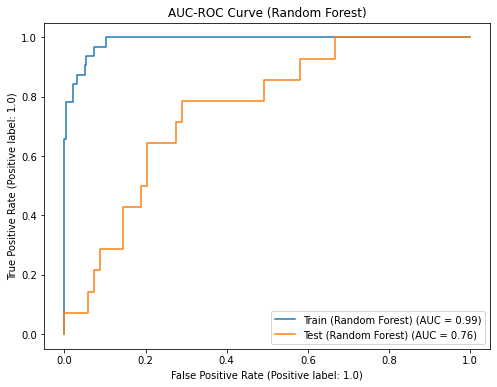

AUC Score: 0.756728778467909


In [81]:
phenotype_mapping = {'yes': 1, 'no': 0, "post_labor_CS":1, "VG":0, "home":0, "hospital":1}
#Test a naive classifier
Phenos = ["infant_health_food_allergy", "infant_health_eczema_diagnosis_relaxed", "infant_health_eczema_diagnosis_strict", "infant_health_breathing_difficulties" ]
Phenos = ["birth_delivery_mode_simple"]
for Phenotype in Phenos :
    print("===={P}=====".format(P=Phenotype))
    Input_ml = Match_x_y(DF2, Meta, Phenotype)
    Input_ml[Phenotype] = Input_ml[Phenotype].map(phenotype_mapping)
    Input_ml = Input_ml[Input_ml[Phenotype].isin([0,1])]
    print(Input_ml[Phenotype].value_counts())
    print("===XGboost===")
    HyperSelect_genetic(Input_ml, Phenotype, CV=5, Model="xgb" )
    #print("===RF===")
    #Run_basic_model(Input_ml, Phenotype, CV=5, Model="rf", Oversampling=True )


Checking that matching is fine. It seems so, so this should not be an issue

In [403]:
DF3 = DF2.sort_values(by="NEXT_ID")
Meta2 = Meta.sort_values(by="NEXT_ID")
print(Meta2[Meta2['NEXT_ID'].isin(DF3['NEXT_ID'])])

merged_df = DF3.merge(Meta, on="NEXT_ID", how="left")
merged_df[ ["NEXT_ID","infant_health_food_allergy", "infant_health_eczema_diagnosis_relaxed","infant_health_breathing_difficulties" ]]

      FAMILY       NEXT_ID infant_health_food_allergy  \
235  FAM0329  LLNEXT001964                         no   
151  FAM0234  LLNEXT002107                         no   
317  FAM0430  LLNEXT002486                        yes   
303  FAM0414  LLNEXT002611                         no   
285  FAM0391  LLNEXT002945                         no   
..       ...           ...                        ...   
602  FAM1364  LLNEXT306289                         no   
605  FAM1378  LLNEXT306836                         no   
609  FAM1400  LLNEXT306927                         no   
621  FAM1479  LLNEXT308778                         no   
320  FAM0435  LLNEXT555599                         no   

    infant_health_eczema_diagnosis_relaxed  \
235                                     no   
151                                    yes   
317                                     no   
303                                     no   
285                                    yes   
..                                     

,NEXT_ID,infant_health_food_allergy,infant_health_eczema_diagnosis_relaxed,infant_health_breathing_difficulties
0,LLNEXT001964,no,no,no
1,LLNEXT002107,no,yes,no
2,LLNEXT002486,yes,no,no
3,LLNEXT002611,no,no,no
4,LLNEXT002945,no,yes,yes
...,...,...,...,...
461,LLNEXT306289,no,no,no
462,LLNEXT306836,no,yes,no
463,LLNEXT306927,no,no,no
464,LLNEXT308778,no,no,yes


In [96]:
print(value_counts_df)
value_counts_df.loc[0]/value_counts_df.loc[1]

1    72
0    39
Name: infant_health_eczema_diagnosis_strict, dtype: int64


0.5416666666666666